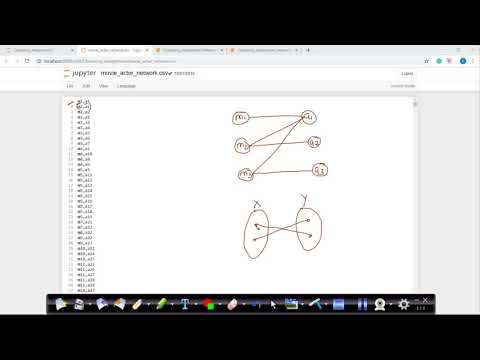

In [1]:
 from IPython.display import IFrame, YouTubeVideo
YouTubeVideo(id='_XJlZtZqMUs', width=600)

In [2]:
pip install networkx==2.3

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import networkx as nx
from sklearn.cluster import KMeans
from networkx.algorithms import bipartite

import warnings
warnings.filterwarnings("ignore")

# Recommended to use Python 3.6 for StellarGraph
# !pip install chardet
from stellargraph import StellarGraph
from stellargraph.data import UniformRandomMetaPathWalk

print(f"networkx verion is '2.3' : {nx.__version__ == '2.3'}")

networkx verion is '2.3' : True


In [4]:
data = pd.read_csv('movie_actor_network.csv', index_col = False, names = ['movie','actor'])

In [5]:
edges = [tuple(x) for x in data.values.tolist()]

In [6]:
B = nx.Graph()
B.add_nodes_from(data['movie'].unique(), bipartite = 0, label = 'movie')
B.add_nodes_from(data['actor'].unique(), bipartite = 1, label = 'actor')
B.add_edges_from(edges, label = 'acted')

In [7]:
'''
connected_component_subgraphs was removed from networkx 2.4
So using networkx==2.3

-------------------------------------------------------------

IF networkx version in 2.5.1 OR > 2.5
https://stackoverflow.com/a/65264264

A = list(B.subgraph(c) for c in nx.connected_components(B))[0]
'''

A = list(nx.connected_component_subgraphs(B))[0]

In [8]:
print("number of nodes", A.number_of_nodes())
print("number of edges", A.number_of_edges())

number of nodes 4703
number of edges 9650


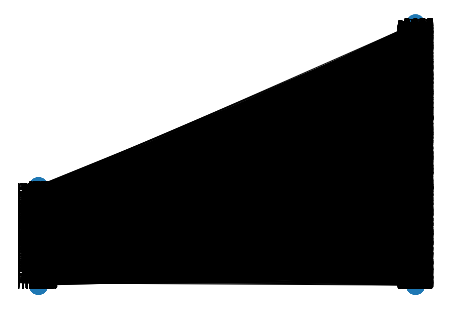

In [9]:
l, r = nx.bipartite.sets(A)
pos = {}

pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))
  
nx.draw(A, pos=pos, with_labels=True)
plt.show()

In [10]:
movies = []
actors = []
for i in A.nodes():
    if 'm' in i:
        movies.append(i)
    if 'a' in i:
        actors.append(i)
print('number of movies ', len(movies))
print('number of actors ', len(actors))

number of movies  1292
number of actors  3411


In [11]:
'''
This code is not working in Matplotlib 3.5.1
So changed into matplotlib 2.1.1
'''
# https://stackoverflow.com/a/53936824
# pip install matplotlib==2.1.1


# Create the random walker
rw = UniformRandomMetaPathWalk(StellarGraph(A))

# specify the metapath schemas as a list of lists of node types.
metapaths = [
    ["movie", "actor", "movie"],
    ["actor", "movie", "actor"]
]

walks = rw.run(nodes=list(A.nodes()), # root nodes
               length=100,  # maximum length of a random walk
               n=1,        # number of random walks per root node 
               metapaths=metapaths
              )

print("Number of random walks: {}".format(len(walks)))

Number of random walks: 4703


In [12]:
from gensim.models import Word2Vec

'''
https://stackoverflow.com/a/70208469

model = Word2Vec(walks, size = 128, window = 5)

`size` parameter was renamed into `vector_size` in new Word2Vec
'''

model = Word2Vec(walks, vector_size = 128, window = 5)

In [13]:
model.wv.vectors.shape  # 128-dimensional vector for each node in the graph

(4703, 128)

In [14]:
# Retrieve node embeddings and corresponding subjects

''' ORIGINAL
node_ids = model.wv.index2word  # list of node IDs
node_embeddings = model.wv.vectors  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = [ A.node[node_id]['label'] for node_id in node_ids]

     ERROR
The index2word attribute has been replaced by index_to_key since Gensim 4.0.0.
'''

node_ids = model.wv.index_to_key  # list of node IDs
node_embeddings = model.wv.vectors  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = [ A.node[node_id]['label'] for node_id in node_ids]

In [15]:
from sklearn.manifold import TSNE

transform = TSNE

trans = transform(n_components = 2) # with perplexity = 30.0
node_embeddings_2d = trans.fit_transform(node_embeddings)

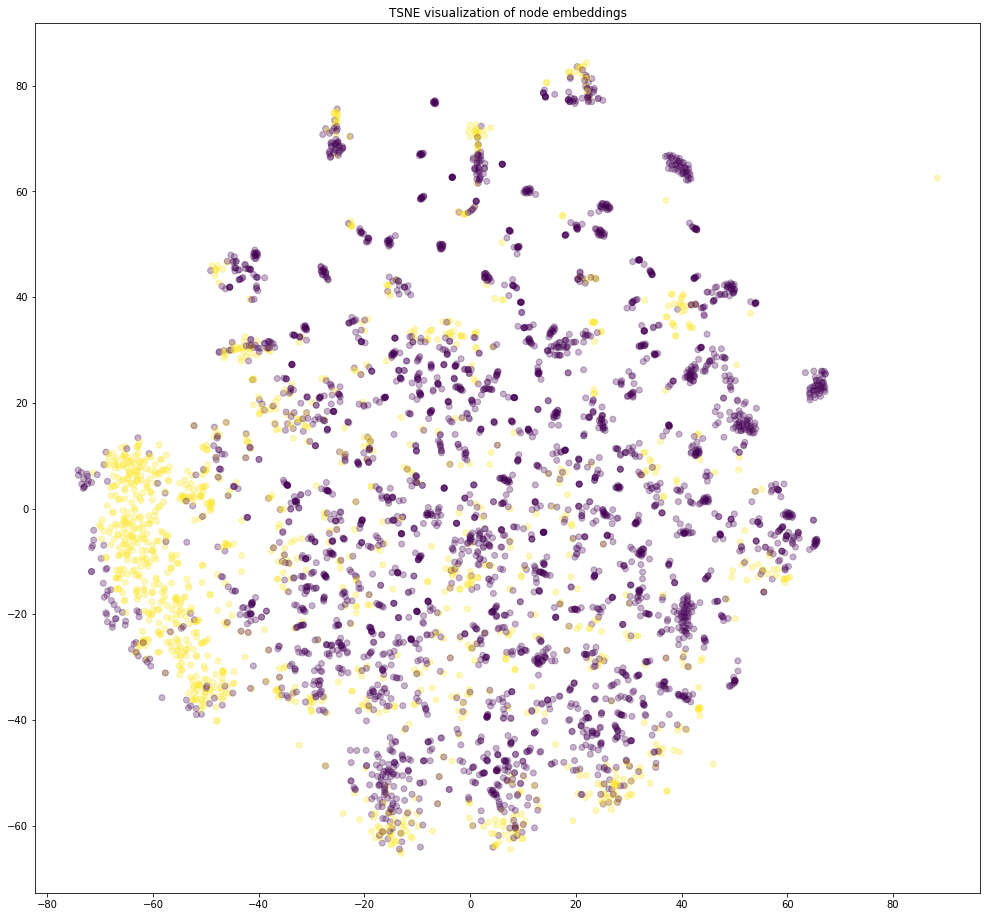

In [16]:
import numpy as np
# draw the points

label_map = { l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = [ label_map[target] for target in node_targets]

plt.figure(figsize = (20, 16))

plt.axes().set(aspect = "equal")
plt.scatter(node_embeddings_2d[:,0], 
            node_embeddings_2d[:,1], 
            c = node_colours, alpha = 0.3)

plt.title('{} visualization of node embeddings'.format(transform.__name__))

plt.show()

In [17]:
from sklearn.decomposition import PCA

transform = PCA

trans = transform(n_components = 2)

node_embeddings_2d = trans.fit_transform(node_embeddings)

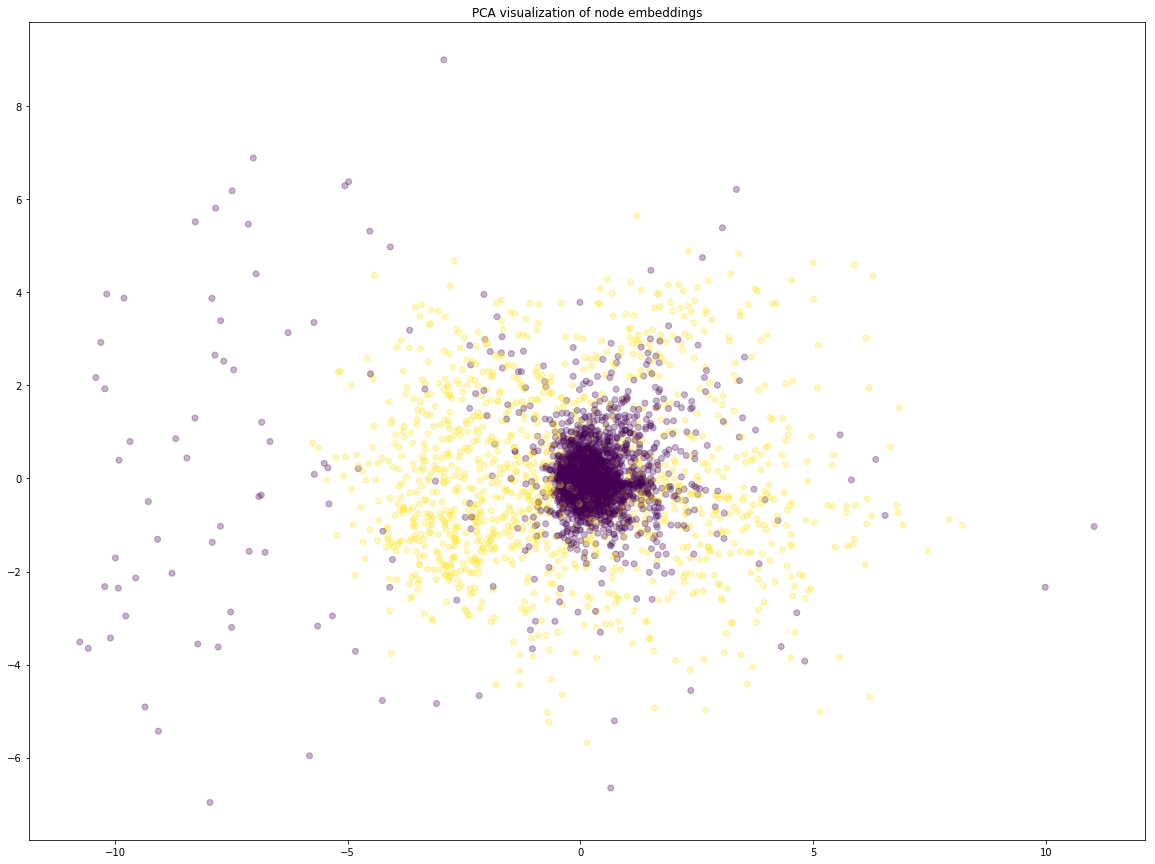

In [18]:
label_map = { l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = [ label_map[target] for target in node_targets]

plt.figure(figsize = (20, 16))

plt.axes().set(aspect = "equal")
plt.scatter(node_embeddings_2d[:,0], 
            node_embeddings_2d[:,1], 
            c = node_colours, alpha = 0.3)

plt.title('{} visualization of node embeddings'.format(transform.__name__))

plt.show()